In [263]:
import json
from pathlib import Path
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from pprint import pprint
from binance import Client
import mt.resources.keys as keys
import statistics as stats

Positions Stats - Smallest: 41.09 USDT, Largest: 129.13 USDT, Average: 89.09 USDT
USDT Stats - Current Balance: 2934.72, Current Sharpe: 2.92, Average daily pnl : 8.83 / 0.30%, Annualised PnL: 299.20%
BTC Stats - Current Balance: 0.04133, Current Sharpe : 0.64, Average daily pnl : -0.00003 / -0.08%


<AxesSubplot: title={'center': 'Execution'}, xlabel='timestamp', ylabel='BPs'>

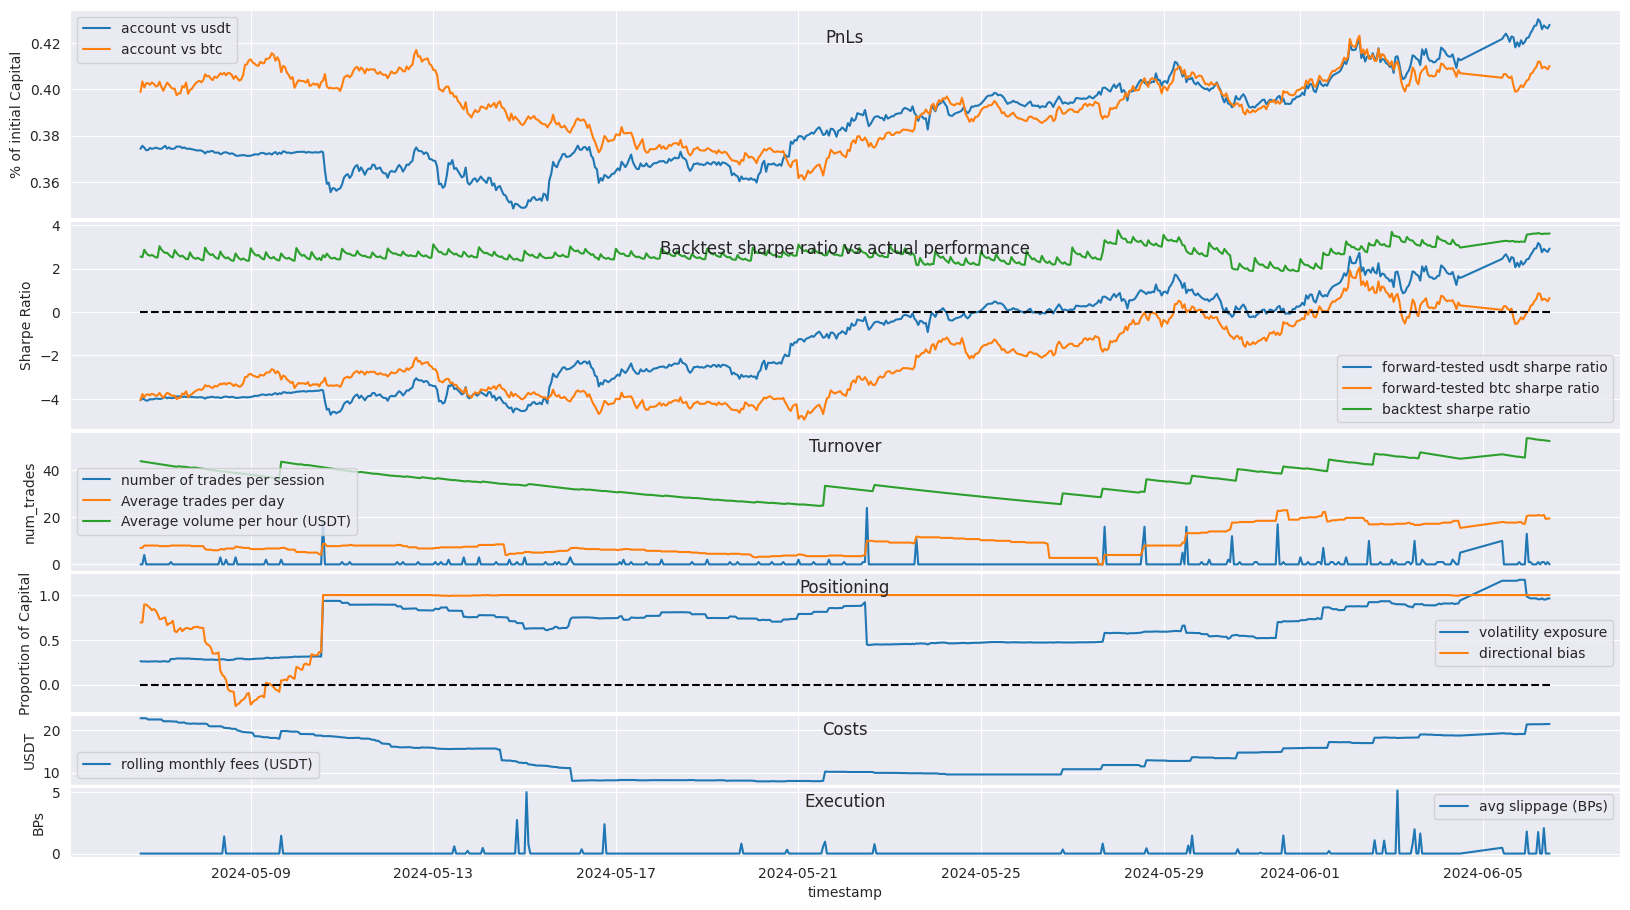

In [293]:
with open(Path("/home/ross/coding/pi_3/modular_trader/continuous/records/trades.json"), 'r') as file:
    trades = json.load(file)
    
trade_df = pl.from_dicts(trades)

trade_df = trade_df.with_columns(
    pl.col('timestamp').cast(pl.Int64).cast(pl.Datetime(time_zone='UTC', time_unit='ms')),
    pl.col('executed_quote_size').cast(pl.Float32),
)

trades_1h = (
    trade_df
    .sort('timestamp')
    .group_by_dynamic(pl.col('timestamp'), every='1h')
    .agg(
            pl.sum('executed_quote_size'),
            pl.sum('usdt_fees'),
            pl.mean('price_impact'),
        )
    .upsample(time_column='timestamp', every='1h')
    .fill_null(0.0)
)

start = trades_1h.item(0, 'timestamp')
trades_1h = pl.DataFrame(
    {
        "timestamp": pl.datetime_range(
            start=start,
            end=datetime.now(tz=timezone.utc),
            interval="1h",
            time_unit='ms',
            eager=True,
        )
    }
).lazy().join(trades_1h.lazy(), on="timestamp", how="left").fill_null(0).collect()

# TODO i want drawdown statistics like max dd, avg dd, max dd duration and avg dd duration and current dd duration - for the backtest and the live trading so i can compare
# TODO i want a breakdown for each coin that shows how much total pnl i have made (accounting for fees), total volume traded, avg pct profit per unit volume etc
# TODO i want some stats like avg pnl per day on a monthly rolling basis, total pnl since records began, and more
# TODO i want to redo the main pnl chart so i take the diff of the account balance series, then add/subtract any transfers in/out of the margin account, then turn it back into a cummulative series for displaying on the chart. that way, the pnl chart won't be affected by profit-taking or adding capital in.

with open(Path("/home/ross/coding/pi_3/modular_trader/continuous/records/session.json"), 'r') as file:
    session_records = json.load(file)

for s in session_records:
    if s.get('volatility_exposure') is None:
        s['volatility_exposure'] = 0.0
    elif s.get('volatility_exposure') > 10:
        s['volatility_exposure'] = 0.9349222790015471

session_records_2 = [s for s in session_records if s.get('bt_sharpe')]
session_records_3 = [s for s in session_records if s.get('volatility_exposure')]

sr = pl.from_dicts(session_records).select(['timestamp', 'usdt_net', 'btc_net', 'trades'])



sr_2 = pl.from_dicts(session_records_2)['bt_sharpe']
sr_3 = pl.from_dicts(session_records_3)['volatility_exposure']

allos = [s[f"{s.get('port_weights', 'flat')}_allocations"] for s in session_records]
abs_allos = [{k: abs(v) for k, v in i.items()} for i in allos]
bias_num = [sum(z.values()) for z in allos]
bias_denom = [sum(z.values()) for z in abs_allos]
bias = pl.Series([x/y for x, y in zip(bias_num, bias_denom)])

capital = [x['usdt_net'] for x in session_records]
both = zip(allos, capital)
sizes = [{k: (abs(v) * c) for k, v in a.items()} for a, c in both]
smallest = min(sizes[-1].values())
largest = max(sizes[-1].values())
avg_size = stats.mean(sizes[-1].values())

pred_exp = pl.Series([sum([abs(v) for v in z.values()]) for z in allos]) * 2

sr_2 = pl.Series([0.0] * (len(sr) - len(sr_2))).extend(sr_2)
sr_3 = pl.Series([0.0] * (len(sr) - len(sr_3))).extend(sr_3)

trades_1h = trades_1h.tail(len(sr))

sharpe_lb = 720# 168 = 1 week, 720 = 30 days, 2190 = 1Q, 8760 = 1 year
sr = sr.with_columns(
    pl.col('timestamp').mul(1000).cast(pl.Int64).cast(pl.Datetime(time_zone='UTC', time_unit='ms')),
    pl.col('usdt_net').truediv(sr.item(0, 'usdt_net')).alias('usdt_pnl_pct'),
    pl.col('btc_net').truediv(sr.item(0, 'btc_net')).alias('btc_pnl_pct'),
    pl.col('usdt_net').diff(24).ewm_mean(span=sharpe_lb).alias('usdt_avg_daily_pnl'),
    pl.col('btc_net').diff(24).ewm_mean(span=sharpe_lb).alias('btc_avg_daily_pnl'),
    pl.col('usdt_net').pct_change().ewm_mean(span=sharpe_lb, min_periods=48).mul(8760).truediv(pl.col('usdt_net').pct_change().ewm_std(span=sharpe_lb, min_periods=48).mul(92)).alias('usdt_sharpe'),
    pl.col('btc_net').pct_change().ewm_mean(span=sharpe_lb, min_periods=48).mul(8760).truediv(pl.col('btc_net').pct_change().ewm_std(span=sharpe_lb, min_periods=48).mul(92)).alias('btc_sharpe'),
    pl.lit(1.0).sub(pl.col('usdt_net').rolling_max(window_size=100_000, min_periods=1).sub(pl.col('usdt_net')).truediv(pl.col('usdt_net').rolling_max(window_size=100_000, min_periods=1))).alias('usdt_dd'),
    pl.lit(1.0).sub(pl.col('btc_net').rolling_max(window_size=100_000, min_periods=1).sub(pl.col('btc_net')).truediv(pl.col('btc_net').rolling_max(window_size=100_000, min_periods=1))).alias('btc_dd'),
    pl.col('trades').alias('num_trades'),
    pl.col('trades').rolling_sum(96).truediv(4).alias('avg_trades'),
    trades_1h['executed_quote_size'].ewm_mean(span=720).alias('avg_hourly_volume'),
    trades_1h['usdt_fees'].rolling_sum(720, min_periods=2).alias('rolling_monthly_fees'),
    trades_1h['price_impact'].alias('avg_slippage'),
    sr_2.alias('bt_sharpe'),
    sr_3.alias('volatility_exposure'),
    bias.alias('bias'),
    # pred_exp.alias('pred_exp')
).tail(sharpe_lb)

daily_pnl = sr.item(-1, 'usdt_avg_daily_pnl') / sr.item(-1, 'usdt_net')
ann_pnl = (daily_pnl + 1) ** 365

print(
    f"Positions Stats - Smallest: {smallest:.2f} USDT, Largest: {largest:.2f} USDT, Average: {avg_size:.2f} USDT"
)
print(
    f"USDT Stats - Current Balance: {sr.item(-1, 'usdt_net'):.2f}, "
    f"Current Sharpe: {sr.item(-1, 'usdt_sharpe'):.2f}, "
    f"Average daily pnl : {sr.item(-1, 'usdt_avg_daily_pnl'):.2f} / {daily_pnl:.2%}, "
    f"Annualised PnL: {ann_pnl:.2%}"
)
print(
    f"BTC Stats - Current Balance: {sr.item(-1, 'btc_net'):.5f}, "
    f"Current Sharpe : {sr.item(-1, 'btc_sharpe'):.2f}, "
    f"Average daily pnl : {sr.item(-1, 'btc_avg_daily_pnl'):.5f} / {sr.item(-1, 'btc_avg_daily_pnl') / sr.item(-1, 'btc_net'):.2%}"
)

fig, ax = plt.subplots(nrows=6, figsize=(20, 11), gridspec_kw=dict(height_ratios=[3, 3, 2, 2, 1, 1]), sharex=True)
fig.subplots_adjust(hspace = 0.02)
ax[0].set_ylabel(ylabel='% of initial Capital')
ax[1].set_ylabel(ylabel='Sharpe Ratio')
ax[2].set_ylabel(ylabel=None)
ax[3].set_ylabel(ylabel='Proportion of Capital')
ax[4].set_ylabel(ylabel='USDT')
ax[5].set_ylabel(ylabel='BPs')
ax[0].set_title('PnLs', y=0.8)
ax[1].set_title('Backtest sharpe ratio vs actual performance', y=0.8)
ax[2].set_title('Turnover', y=0.8)
ax[3].set_title('Positioning', y=0.8)
ax[4].set_title('Costs', y=0.6)
ax[5].set_title('Execution', y=0.6)

sns.lineplot(data=sr, x='timestamp', y='usdt_pnl_pct', label='account vs usdt', ax=ax[0])
sns.lineplot(data=sr, x='timestamp', y='btc_pnl_pct', label='account vs btc', ax=ax[0])
# sns.lineplot(data=sr, x='timestamp', y='usdt_dd', label='drawdown vs usdt', ax=ax[0])
# sns.lineplot(data=sr, x='timestamp', y='btc_dd', label='drawdown vs btc', ax=ax[0])

sns.lineplot(data=sr, x='timestamp', y='usdt_sharpe', label='forward-tested usdt sharpe ratio', ax=ax[1])
sns.lineplot(data=sr, x='timestamp', y='btc_sharpe', label='forward-tested btc sharpe ratio', ax=ax[1])
sns.lineplot(data=sr, x='timestamp', y='bt_sharpe', label='backtest sharpe ratio', ax=ax[1])
sns.lineplot(data=sr, x='timestamp', y=0, color='black', linestyle='--', ax=ax[1])

sns.lineplot(data=sr, x='timestamp', y='num_trades', label='number of trades per session', ax=ax[2])
sns.lineplot(data=sr, x='timestamp', y='avg_trades', label='Average trades per day', ax=ax[2])
sns.lineplot(data=sr, x='timestamp', y='avg_hourly_volume', label='Average volume per hour (USDT)', ax=ax[2])

sns.lineplot(data=sr, x='timestamp', y='volatility_exposure', label='volatility exposure', ax=ax[3])
sns.lineplot(data=sr, x='timestamp', y='bias', label='directional bias', ax=ax[3])
# sns.lineplot(data=sr, x='timestamp', y='pred_exp', label='predicted exposure', ax=ax[3])
sns.lineplot(data=sr, x='timestamp', y=0, color='black', linestyle='--', ax=ax[3])

sns.lineplot(data=sr, x='timestamp', y='rolling_monthly_fees', label='rolling monthly fees (USDT)', ax=ax[4])
sns.lineplot(x=sr['timestamp'], y=sr['avg_slippage']*10_000, label='avg slippage (BPs)', ax=ax[5])

# statistics


In [200]:
from binance.client import Client as Client_b
import mt.resources.keys as keys
client = Client_b(keys.bPkey, keys.bSkey)
m_acct = client.get_margin_account()

In [75]:
m_acct.keys()

dict_keys(['tradeEnabled', 'transferEnabled', 'borrowEnabled', 'marginLevel', 'totalAssetOfBtc', 'totalLiabilityOfBtc', 'totalNetAssetOfBtc', 'userAssets', 'collateralMarginLevel', 'totalCollateralValueInUSDT', 'accountType'])

In [76]:
m_acct['totalAssetOfBtc']

'0.04074035'

In [77]:
m_acct['totalNetAssetOfBtc']

'0.03900054'

In [81]:
sr[-1]

timestamp,usdt_net,btc_net,trades,usdt_pnl_pct,btc_pnl_pct,usdt_sharpe,btc_sharpe,usdt_dd,btc_dd,num_trades,avg_trades,bt_sharpe,volatility_exposure,bias
"datetime[ms, UTC]",f64,f64,i64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64
2024-05-27 21:00:04.506 UTC,2748.385796,0.039455,0,0.400692,0.391409,0.702907,-1.390041,0.397478,0.39071,0,4.0,2.698719,0.576329,0.524


In [42]:
trades_1h['executed_quote_size'].sum()

265222.15625

In [251]:
session_records

[{'timestamp': 1710759988.565381,
  'port_weights': 'perf',
  'usdt_net': 6859.096245400716,
  'btc_net': 0.10080339,
  'max_leverage': 3,
  'buffer': 0.2,
  'flat_allocations': {'BTCUSDT': 0.053717894110824005,
   'SOLUSDT': 0.10486330219532364,
   'NEARUSDT': 0.05998044039681414,
   'ROSEUSDT': -0.00016189718779954296,
   'OCEANUSDT': 0.024689402997236737,
   'ETHUSDT': -0.004010520065064676,
   'MATICUSDT': -0.04176164327650449,
   'AVAXUSDT': 0.075835960999921},
  'lin_allocations': {'BTCUSDT': 0.09549847841924267,
   'SOLUSDT': 0.16312069230383677,
   'NEARUSDT': 0.07997392052908552,
   'ROSEUSDT': -0.0001798857642217144,
   'OCEANUSDT': 0.021946135997543765,
   'ETHUSDT': -0.0026736800433764503,
   'MATICUSDT': -0.018560730345113106,
   'AVAXUSDT': 0.016852435777760223},
  'perf_allocations': {'BTCUSDT': 0.01766164618594348,
   'SOLUSDT': 0.1771286172572418,
   'NEARUSDT': 0.05980203270580747,
   'ROSEUSDT': -0.00012278009295297812,
   'OCEANUSDT': 0.0,
   'ETHUSDT': -0.003306859

In [185]:
test = (
    pl.read_parquet("/home/ross/coding/modular_trader/bin_ohlc_5m/1INCHUSDT.parquet")
    .sort(by='timestamp')
    .group_by_dynamic(pl.col('timestamp'), every='1d')
    .agg(
        pl.first('open'),
        pl.max('high'),
        pl.min('low'),
        pl.last('close'),
        pl.sum('base_vol'),
        pl.sum('quote_vol'),
        pl.sum('num_trades'),
        pl.sum('taker_buy_base_vol'),
        pl.sum('taker_buy_quote_vol'),
    )
    .upsample(time_column='timestamp', every='1h')
    .fill_null(0.0)
)

test

timestamp,open,high,low,close,base_vol,quote_vol,num_trades,taker_buy_base_vol,taker_buy_quote_vol
"datetime[ns, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64
2020-12-25 00:00:00 UTC,0.2,3.0885,0.2,2.2954,1.2598e8,3.0151e8,616984.0,6.2087e7,1.4914e8
2020-12-25 01:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 02:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 03:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 04:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 05:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 06:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 07:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 08:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [186]:
start = test.item(0, 'timestamp')
test = pl.DataFrame(
    {
        "timestamp": pl.datetime_range(
            start=start,
            end=datetime.now(tz=timezone.utc),
            interval="1h",
            time_unit='ns',
            eager=True,
        )
    }
).lazy().join(test.lazy(), on="timestamp", how="left")


In [187]:
test.collect()

timestamp,open,high,low,close,base_vol,quote_vol,num_trades,taker_buy_base_vol,taker_buy_quote_vol
"datetime[ns, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64
2020-12-25 00:00:00 UTC,0.2,3.0885,0.2,2.2954,1.2598e8,3.0151e8,616984.0,6.2087e7,1.4914e8
2020-12-25 01:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 02:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 03:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 04:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 05:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 06:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 07:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 08:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [289]:
# load old records as all_transfers
trans_records = Path("records/transfers.json")
try:
    with open(trans_records, 'r') as f:
        all_transfers = json.load(f)
except FileNotFoundError:
    all_transfers = []

client = Client(keys.bPkey, keys.bSkey)
new_transfers = client.get_margin_transfer_history()['rows']


t = pl.from_dicts(new_transfers)
t = t.with_columns(
    pl.col('timestamp').cast(pl.Int64).cast(pl.Datetime(time_zone='UTC', time_unit='ms'))
)

trans_total = 0
all_ids = [q['txId'] for q in all_transfers]
for n, i in enumerate(new_transfers):
    mult = 1 if i['type'] == 'ROLL_IN' else -1
    if i.get('txId') in all_ids:
        continue
    if i['asset'] == 'USDT':
        usdt_value = float(i['amount']) * mult
        new_transfers[n]['usdt_value'] = usdt_value
    else:
        filepath = f"/home/ross/coding/modular_trader/bin_ohlc_5m/{i['asset']}USDT.parquet"
        ts = datetime.fromtimestamp(i['timestamp'] / 1000, tz=timezone.utc)
        ohlc = pl.read_parquet(filepath).filter(pl.col('timestamp').lt(ts))
        usdt_value = ohlc.item(-1, 'close') * float(i['amount']) * mult
        new_transfers[n]['usdt_value'] = usdt_value
    all_transfers.append(i)
 
t = pl.from_dicts(all_transfers)
t = t.with_columns(
    pl.col('timestamp').cast(pl.Int64).cast(pl.Datetime(time_zone='UTC', time_unit='ms'))
)
print(t)

with open(trans_records, 'w') as f:
    json.dump(all_transfers, f)

shape: (4, 9)
┌────────────┬───────┬────────────┬──────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ timestamp  ┆ asset ┆ amount     ┆ type     ┆ … ┆ txId       ┆ transFrom  ┆ transTo   ┆ usdt_valu │
│ ---        ┆ ---   ┆ ---        ┆ ---      ┆   ┆ ---        ┆ ---        ┆ ---       ┆ e         │
│ datetime[m ┆ str   ┆ str        ┆ str      ┆   ┆ i64        ┆ str        ┆ str       ┆ ---       │
│ s, UTC]    ┆       ┆            ┆          ┆   ┆            ┆            ┆           ┆ f64       │
╞════════════╪═══════╪════════════╪══════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 2024-06-01 ┆ USDT  ┆ 9.95680036 ┆ ROLL_IN  ┆ … ┆ 1761750028 ┆ SPOT       ┆ CROSS_MAR ┆ 9.9568    │
│ 23:36:38   ┆       ┆            ┆          ┆   ┆ 14         ┆            ┆ GIN       ┆           │
│ UTC        ┆       ┆            ┆          ┆   ┆            ┆            ┆           ┆           │
│ 2024-06-01 ┆ ETH   ┆ 0.003      ┆ ROLL_IN  ┆ … ┆ 1761747283 ┆ SPOT       ┆ 